# Training

## Setup

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/tiger_classification

/content/drive/MyDrive/tiger_classification


In [4]:
!pip3 install keras kimm -U

In [5]:
import os
import random
import shutil
import numpy as np

import keras
from keras import layers, optimizers, losses, callbacks
import kimm
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def sample_images(source_dir, target_dir, samples_per_class, seed=42):
    """
    Samples a fixed number of images per class from a directory structure.

    Args:
        source_dir (str): Path to the source dataset directory.
        target_dir (str): Path to the target dataset directory to store sampled data.
        samples_per_class (int): Number of images to sample per class.
        seed (int): Random seed for reproducibility.
    """
    random.seed(seed)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            sampled_class_dir = os.path.join(target_dir, class_name)
            os.makedirs(sampled_class_dir, exist_ok=True)

            # list and shuffle all files in class directory
            all_images = os.listdir(class_path)
            random.shuffle(all_images)

            # select desired number of samples
            sampled_images = all_images[:samples_per_class]

            # copy sampled images to new directory
            for image_name in sampled_images:
                source_image_path = os.path.join(class_path, image_name)
                target_image_path = os.path.join(sampled_class_dir, image_name)
                shutil.copy(source_image_path, target_image_path)

In [7]:
# set seed
seed = 42

# set batch size
batch_size = 16

# set num classes
num_classes = 5

# define paths to train and test images
train_dir = 'images/train'
train_dir_sampled = 'images/train_sampled'
test_dir = 'images/test'
test_dir_sampled = 'images/test_sampled'
test2_dir = 'images/test2'

## Prepare train and test datasets

In [8]:
!ls images/train/class_1 | wc -l
!ls images/train/class_2 | wc -l
!ls images/train/class_3 | wc -l
!ls images/train/class_4 | wc -l
!ls images/train/class_5 | wc -l

4896
839
655
1223
1103


In [9]:
!ls images/test/class_1 | wc -l
!ls images/test/class_2 | wc -l
!ls images/test/class_3 | wc -l
!ls images/test/class_4 | wc -l
!ls images/test/class_5 | wc -l

2825
214
163
319
255


In [10]:
!ls images/test2/class_1 | wc -l

307


In [11]:
# create new directory with sampled train images
!rm -rf "$train_dir_sampled"
sample_images(train_dir, train_dir_sampled, 500)

In [12]:
# create new directory with sampled test images
!rm -rf "$test_dir_sampled"
sample_images(test_dir, test_dir_sampled, 150)

In [13]:
# create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_sampled,
    label_mode='categorical',
    shuffle=True,
    seed=seed
)

# create test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_sampled,
    label_mode='categorical',
    shuffle=False
)

# create test2 dataset
test2_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test2_dir,
    label_mode='categorical',
    shuffle=False
)

# we need to unbatch because there's somehow an unwanted additional dimension
train_ds = train_ds.unbatch()
test_ds = test_ds.unbatch()
test2_ds = test2_ds.unbatch()

print(f'Number of train samples: {train_ds.cardinality()}')
print(f'Number of test samples: {test_ds.cardinality()}')

Found 2500 files belonging to 5 classes.
Found 750 files belonging to 5 classes.
Found 307 files belonging to 1 classes.
Number of train samples: -2
Number of test samples: -2


In [14]:
# check dimensions
print(train_ds.element_spec, test_ds.element_spec)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None)) (TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))


In [15]:
# setup dataset with tf.data
resize_fn = keras.layers.Resizing(224, 224)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))
test2_ds = test2_ds.map(lambda x, y: (resize_fn(x), y))

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test2_ds = test2_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

## Prepare model

In [16]:
# create base model
base_model = kimm.models.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_preprocessing=True,
    include_top=False,
)

# freeze base model
base_model.trainable = False

# create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # regularize with dropout
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ EfficientNetV2B0 (EfficientNetV2B0) │ (None, 7, 7, 1280)           │     5,919,312 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 5)                    │         6,405 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 5,925,717 (22.60 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## Training

Follow [mewc-train](https://github.com/zaandahl/mewc-train)

In [17]:
# df_size = 2500

epochs = 30

lr_init = 1e-4
# min_lr_frac = 1/5 # default minimum learning rate fraction of initial learning rate
# steps_per_epoch = df_size // batch_size
# total_steps = epochs * steps_per_epoch # total number of steps for monotonic exponential decay across all epochs
# lr = optimizers.schedules.ExponentialDecay(initial_learning_rate=lr_init, decay_steps=total_steps, decay_rate=min_lr_frac, staircase=False)
amsgrad = True
weight_decay = 1e-4
optimizer = optimizers.AdamW(learning_rate=lr_init, amsgrad=amsgrad, weight_decay=weight_decay)

# if num_classes == 2:
#   loss_f = losses.BinaryFocalCrossentropy()  # use for binary classification tasks
#   act_f = 'sigmoid' # use for binary classification tasks
# else:
#   loss_f = losses.CategoricalFocalCrossentropy()  # use for unbalanced multi-class tasks (typical for wildlife datasets)
#   act_f = 'softmax' # use for multi-class classification tasks
loss_f = losses.CategoricalCrossentropy()

metrics = ['accuracy']

callbacks = [callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=5, restore_best_weights=True)]

In [18]:
model.compile(
    optimizer=optimizer,
    loss=loss_f,
    metrics=metrics,
)

In [19]:
model.fit(train_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/30
    157/Unknown 44s 135ms/step - accuracy: 0.3464 - loss: 1.5486

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - accuracy: 0.3471 - loss: 1.5477
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6776 - loss: 1.0602
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7899 - loss: 0.8145
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8038 - loss: 0.6863
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8175 - loss: 0.6044
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8476 - loss: 0.5413
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8485 - loss: 0.5121
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8617 - loss: 0.4722
Epoch 9/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8700 - loss: 0.4495
Epoch 10/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8696 - loss: 0.4282
Epoch 11/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8745 - loss: 0.4160
Epoch 12/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/

In [20]:
!mkdir -p model
model.save('model/model.h5', save_format='h5')

## Evaluation

In [21]:
result = model.evaluate(test_ds)
print(f'Test accuracy: {result[1] * 100:3.2f}%')

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - accuracy: 0.9298 - loss: 0.2295
Test accuracy: 90.00%


In [22]:
result2 = model.evaluate(test2_ds)
print(f'Test2 accuracy: {result2[1] * 100:3.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.8202 - loss: 20.8670
Test2 accuracy: 83.39%


In [23]:
true_labels = []
predicted_classes = []

for images, labels in test_ds:
    # append true labels based on their format
    if len(labels.shape) > 1:  # if one-hot encoded
        true_labels.append(np.argmax(labels.numpy(), axis=1))
    else:  # if integer labels
        true_labels.append(labels.numpy())

    # predict classes
    predictions = model.predict(images)
    predicted_classes.append(np.argmax(predictions, axis=1))

# combine all batches into single arrays
true_labels = np.concatenate(true_labels)
predicted_classes = np.concatenate(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

In [24]:
cm = confusion_matrix(true_labels, predicted_classes)
print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[145   0   3   2   0]
 [  0 131   4   5  10]
 [  0   1 142   2   5]
 [  2  10   5 120  13]
 [  3   0   4   6 137]]


In [25]:
class_names = ['tiger', 'lynx', 'bear', 'deer', 'bird']
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

       tiger       0.97      0.97      0.97       150
        lynx       0.92      0.87      0.90       150
        bear       0.90      0.95      0.92       150
        deer       0.89      0.80      0.84       150
        bird       0.83      0.91      0.87       150

    accuracy                           0.90       750
   macro avg       0.90      0.90      0.90       750
weighted avg       0.90      0.90      0.90       750



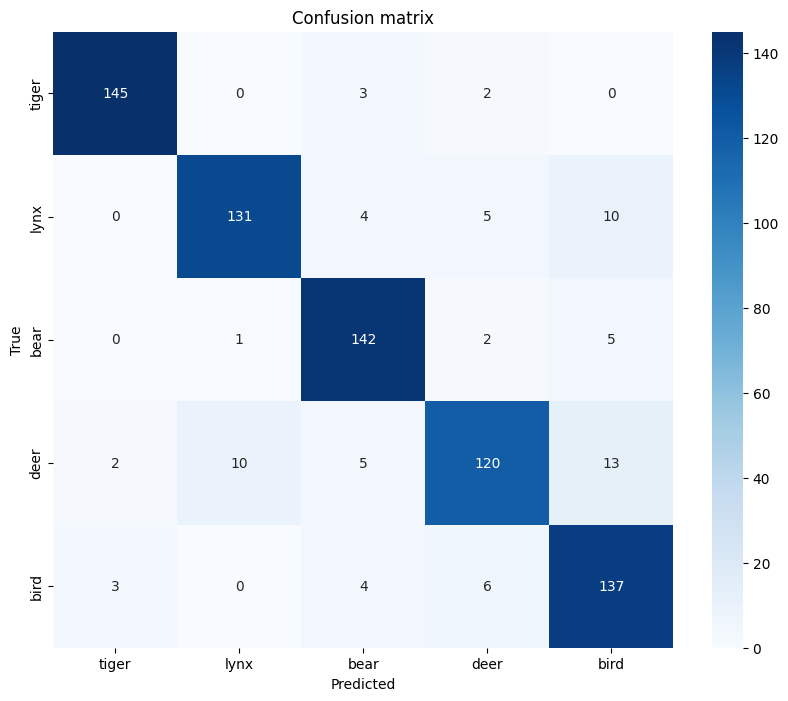

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()